---
format: 
    html:
        embed-resources: true
---

## Predict whether a customer will churn

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv('data/Telco-Customer-Churn.csv')

# Delete useless columns
df = df.drop(['customerID'], axis=1)

# Process TotalCharges, converting it to numbers and handling missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.fillna(0) # fill missing values

# Label encoding binary features
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in binary_cols:
 df[col] = LabelEncoder().fit_transform(df[col])

# One-hot encoding multi-category features
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

# Confirm whether the data processing is complete
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   int64  
 1   SeniorCitizen                          7043 non-null   int64  
 2   Partner                                7043 non-null   int64  
 3   Dependents                             7043 non-null   int64  
 4   tenure                                 7043 non-null   int64  
 5   PhoneService                           7043 non-null   int64  
 6   MultipleLines                          7043 non-null   int64  
 7   OnlineSecurity                         7043 non-null   int64  
 8   OnlineBackup                           7043 non-null   int64  
 9   DeviceProtection                       7043 non-null   int64  
 10  TechSupport                            7043 non-null   int64  
 11  Stre

Random Forest Accuracy: 0.7984386089425124
Confusion Matrix:
 [[950  86]
 [198 175]]


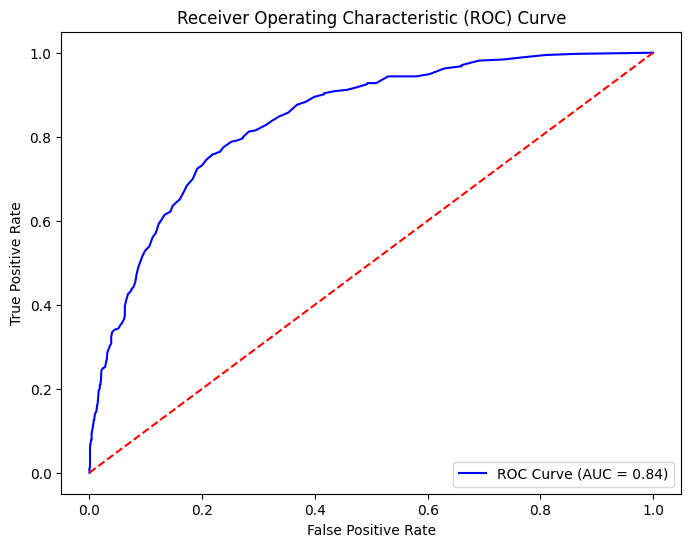

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Split the dataset into training and test sets
X = df.drop(['Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output results
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Predict housing prices or sales

Mean Squared Error (MSE): 0.019075734664851813
R² Score: 0.8969042387871241


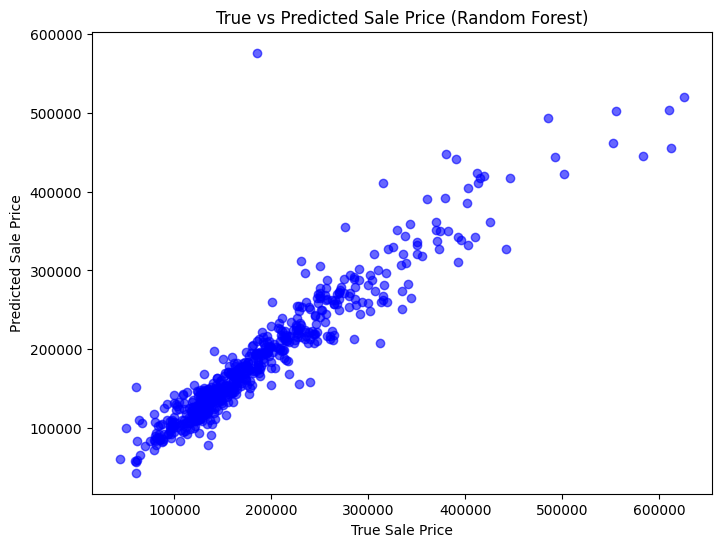

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('data/AmesHousing.csv')

# Data cleaning
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('None')  # Fill missing categorical values
    else:
        df[col] = df[col].fillna(df[col].median())  # Fill missing numerical values

# Log transformation of target variable
df['SalePrice'] = np.log1p(df['SalePrice'])

# One-Hot encoding for categorical variables
df = pd.get_dummies(df, drop_first=True)

# Feature selection based on correlation
corr_matrix = df.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(20).index
X = df[top_features].drop(['SalePrice'], axis=1)
y = df['SalePrice']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=30,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

# Visualize the prediction results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), alpha=0.6, color='blue')  # Transform log back to original scale
plt.xlabel("True Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("True vs Predicted Sale Price (Random Forest)")
plt.show()


## Analyze and segment customers

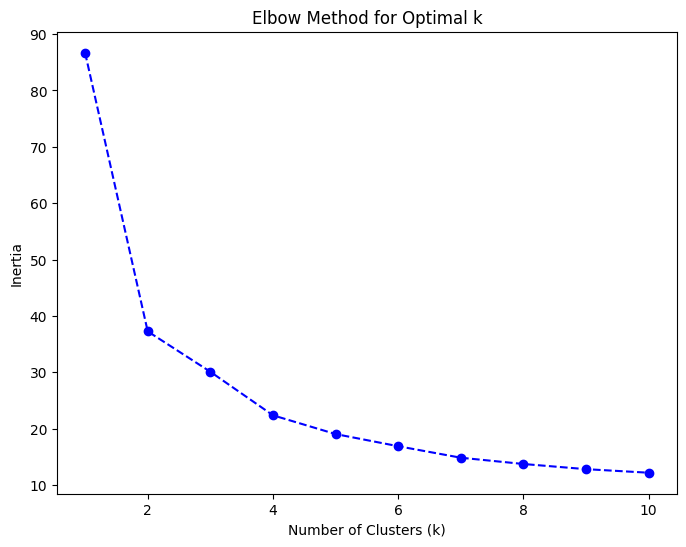

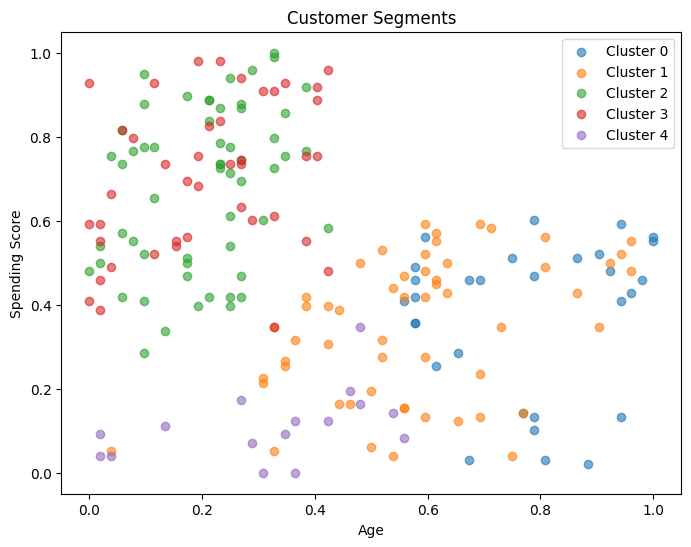

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# Set environment variables to avoid Loky warnings
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

# Read data
df = pd.read_csv('data/Mall_Customers.csv')

# Data cleaning
df.drop(['CustomerID'], axis=1, inplace=True)

# One-Hot Encoding
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Standardize data
scaler = MinMaxScaler()
df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(
 df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
)

# Use Elbow Method to find the best K
inertia = []
k_range = range(1, 11)
for k in k_range:
 kmeans = KMeans(n_clusters=k, random_state=42)
 kmeans.fit(df)
 inertia.append(kmeans.inertia_)

# Draw the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, 'o--', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Best K value for clustering
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(df)

# Draw the clustering results
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
 cluster_data = df[df['Cluster'] == cluster]
 plt.scatter(cluster_data['Age'], cluster_data['Spending Score (1-100)'], label=f'Cluster {cluster}', alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.title('Customer Segments')
plt.legend()
plt.show()